In [11]:
import numpy as np
import pandas as pd
import tempfile
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.control as control
import matplotlib.pyplot as plt
%matplotlib inline 

In [12]:
def timeseries_example(net, output_dir):
    # 1. create (random) data source
    n_timesteps = 24
    profiles, ds = create_data_source(n_timesteps)
    # 2. create controllers 
    create_controllers(net, ds)
    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)
    # 3. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)
    return ow

In [13]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net= pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b2, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')

    return net

In [25]:
gen = pd.read_excel("actual_generation_renewables.xlsx",usecols=["Total_MWh"])
ds1 = DFData(gen)

,Total_MWh
0,5867
1,5916
2,5875
3,5830
4,5752
...,...
187,4197
188,4272
189,4252
190,4218


In [20]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 20.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 20.
    profiles['c'] = 0.95 + np.random.random(n_timesteps) * (1.05-0.95)

    ds = DFData(profiles)
    
    # a + r*k
    # k = b-a
    # range between a and b within k

    return profiles, ds


In [5]:
def create_controllers(net, ds):
    c = control.ContinuousTapControl(net=net, tid=0, vm_set_pu=0.98, tol=1e-6)
    ConstControl(net, element='controller', variable='object.vm_set_pu', element_index=c.index, data_source=ds, 
                 profile_name='c')
    #ConstControl(net, element='sgen', variable='p_mw', element_index=0, data_source=ds, profile_name='sgen1_p')
    #ConstControl(net, element='load', variable='p_mw', element_index=0, data_source=ds, profile_name='load1_p')

In [6]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xls", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_sgen', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    #ow.log_variable("trafo","tap_pos")
    return ow

In [7]:
net = simple_test_net()

ow = timeseries_example(net, None)
pp.timeseries.run_time_series.run_timeseries(net, time_steps=range(24))

100%|██████████| 24/24 [00:04<00:00,  5.11it/s]


In [8]:
def plot_results(ow, variable, title):
    p= ow.output[variable]
    p.plot(label=variable)
    plt.xlabel("time step")
    plt.ylabel(variable)
    plt.title(title)
    plt.grid()
    plt.show()

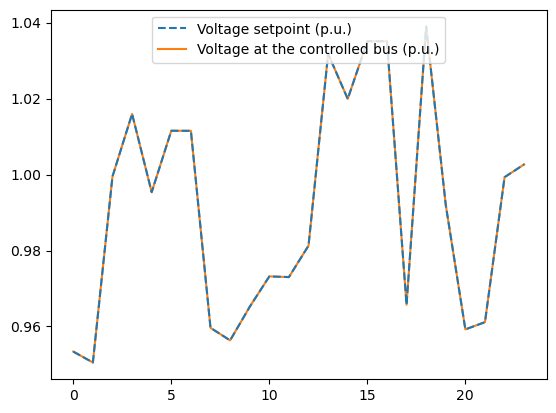

In [9]:
ax=net.controller.at[1,'object'].data_source.df['c'].plot(zorder=1, linestyle='--', label='Voltage setpoint (p.u.)')
ow.output['res_bus.vm_pu'][net.trafo.at[0, 'lv_bus']].plot(ax=ax, zorder=0, label='Voltage at the controlled bus (p.u.)')
ax.legend(loc='upper center')

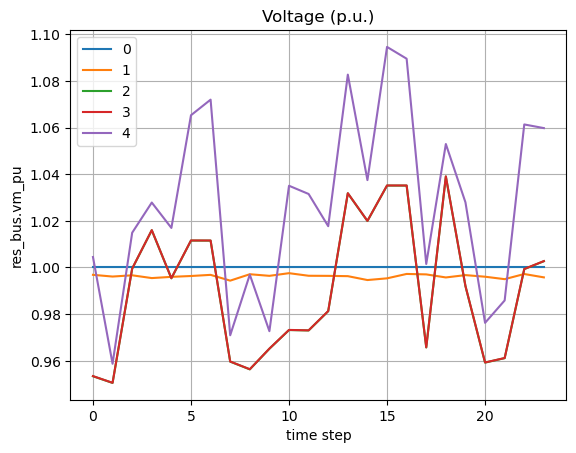

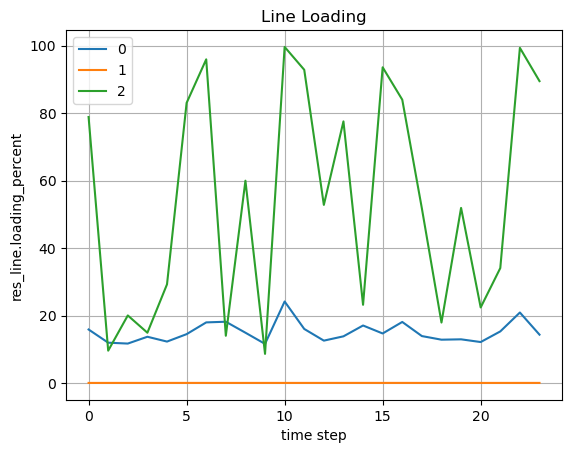

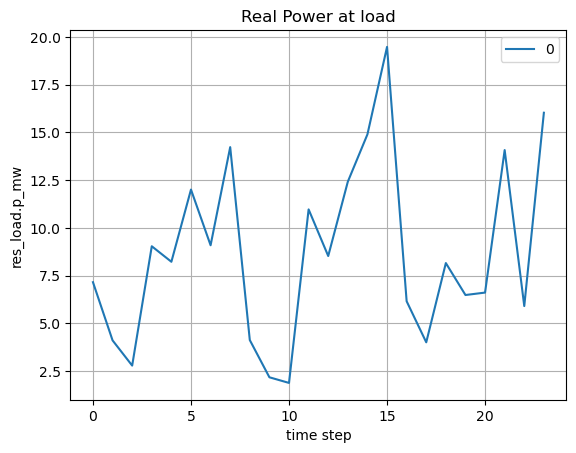

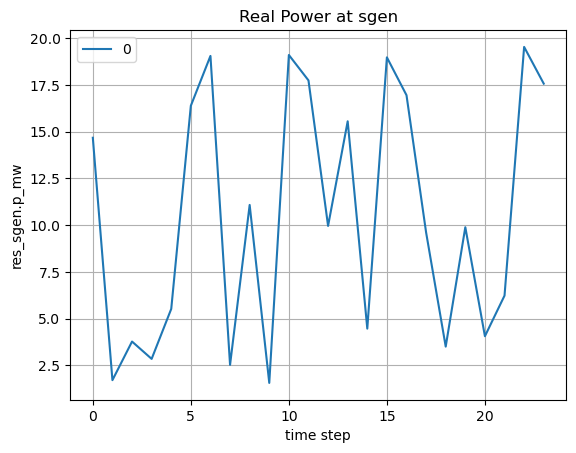

In [10]:
#plot_results(ow,"trafo.tap_pos","Tap Position")
plot_results(ow, 'res_bus.vm_pu', 'Voltage (p.u.)')
plot_results(ow, 'res_line.loading_percent', 'Line Loading')
plot_results(ow, 'res_load.p_mw', 'Real Power at load')
plot_results(ow, 'res_sgen.p_mw', 'Real Power at sgen')